#### About the Analysis:

##### The main purpose of this notebook is to explore some of the features with respect to LIHTC( Low Income Housing Tax Credit )  program data for Florida and compare it with the rest of the USA. 

##### But before doing that, we first loaded the NHPD data and checked the overall structure of the dataset. We also found that there are many features that have around 80-100% NAs. 

##### We then checked the top 10 cities, counties and states that are present in the dataset and did a small univariate and bivariate analysis of features such as occupancy rates, fair market rate etc. before jumping to the LIHTC program data columns for Florida and compared them with rest of the USA.

#### Findings:

##### 1. Although we didnt see much of a strong trend when comparing the occupancy rate w.r.t fair market rent, but we did find some clusters that shows the occupancy rate is high when the fair market rate is less. 

##### 2. For Florida there are around 120 LIHTC assisted units that are covered with subsidies on an average, whereas for the rest of the USA, its around 60

##### 3. On an average there are just 2-4 active LIHTC subsidies per city in Florida and when compared with the rest of the USA the numbers are almost the same per city

In [338]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [339]:
nhpd = pd.read_excel('Active and Inconclusive Properties.xlsx')

In [340]:
nhpd.shape

(82287, 252)

In [341]:
# Let's find the percent of missing values in each column. 

def find_missing(df: pd.DataFrame):
    """
    Calculates the percent of missing values in a given dataset
    param df: The dataframe for which we want to calculate the percent of missing values in each column
    """
    
    missing = df.isnull().sum()
    
    percent_missing = missing * 100/ len(df)
    
    missing_df = pd.DataFrame({'col': df.columns, 'percent_missing': percent_missing})
    
    #sort them in decreasing order
    missing_df.sort_values(by = 'percent_missing', ascending= False, inplace=True)
    
    return missing_df
    
    

missing_values = find_missing(nhpd)


In [342]:
# number of columns with more than 90% missing data
df_subset_90 = missing_values[missing_values['percent_missing'] >= 90]
df_subset_90['col'].nunique()

137

In [343]:
# number of columns with less than 30% missing data
df_subset_30 = missing_values[missing_values['percent_missing'] <= 30]
df_subset_30['col'].nunique()

62

In [344]:
# number of columns with less than 100% missing data
df_subset_100 = missing_values[missing_values['percent_missing'] == 100]
df_subset_100['col'].nunique()

18

In [345]:
no_missing_list = df_subset_90['col'].unique().tolist()

In [346]:
nhpd_subset = nhpd.loc[:, nhpd.columns.isin(no_missing_list)]
nhpd_subset.columns

Index(['S8_1_InacStatusDesc', 'S8_2_ID', 'S8_2_Status', 'S8_2_ProgramName',
       'S8_2_RenewalStatus', 'S8_2_StartDate', 'S8_2_EndDate',
       'S8_2_AssistedUnits', 'S8_2_RentToFMR', 'S8_2_InacStatusDesc',
       ...
       'Pbv_1_AssistedUnits', 'Pbv_2_Status', 'Pbv_2_ProgramName',
       'Pbv_2_AssistedUnits', 'Mr_1_Status', 'Mr_1_ProgramName',
       'Mr_1_AssistedUnits', 'Mr_2_Status', 'Mr_2_ProgramName',
       'Mr_2_AssistedUnits'],
      dtype='object', length=137)

#### Analyzing some important features on the overall data such as occupancy rate, fair market rate etc. to get some initial insights

In [347]:
def univariate_analysis(df:pd.DataFrame, col: str):
    """
    Takes a dataframe and a column name to plot the 
    param df: dataframe
    param col: column name for which we want the viz
    """
    
    df[col].value_counts().head(10).sort_values(ascending=True).plot.barh()    

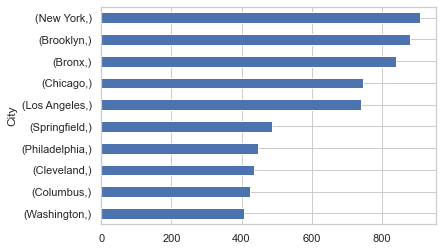

In [348]:
# Top ten cities present in the dataset
univariate_analysis(nhpd, ['City'])

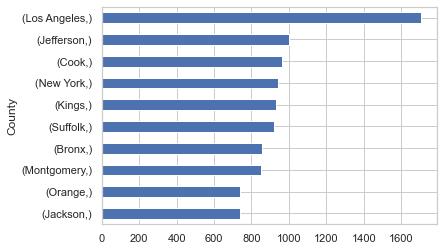

In [349]:
# Top ten counties present in the dataset
univariate_analysis(nhpd, ['County'])

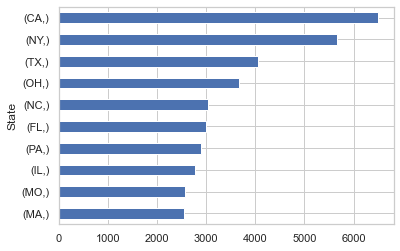

In [350]:
# Top ten states present in the dataset
univariate_analysis(nhpd, ['State'])

#### occupancy rate Vs fair market rate: Although we didnt see much of a strong trend when comparing the occupancy rate w.r.t fair market rent, but we did find some clusters that shows the occupancy rate is high when the fair market rate is less. 

<AxesSubplot:xlabel='FairMarketRent_2BR', ylabel='OccupancyRate'>

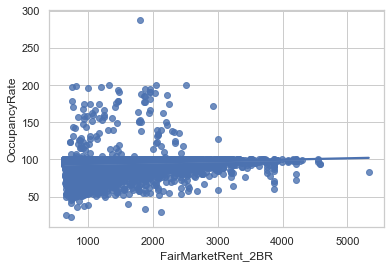

In [351]:
sns.regplot(data=nhpd, x="FairMarketRent_2BR", y="OccupancyRate")

<AxesSubplot:xlabel='FairMarketRent_2BR', ylabel='AverageMonthsOfTenancy'>

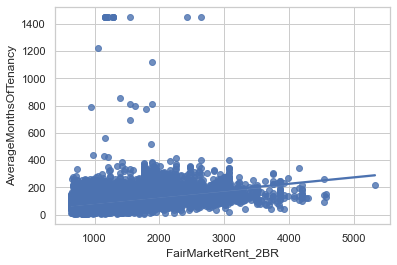

In [352]:
sns.regplot(data=nhpd, x="FairMarketRent_2BR", y="AverageMonthsOfTenancy")

##### Next we are going to figure the Fair market rent for target tenant type:

In [353]:
import fuzzywuzzy
from fuzzywuzzy import process
import chardet

def match_and_replace(df, column, string_to_match, min_ratio = 50):
    unique_strings = df[column].unique()
    get_matches = fuzzywuzzy.process.extract(string_to_match, unique_strings, 
                                         limit=20, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
    matches = [get_matches[0] for get_matches in get_matches if get_matches[1] >= min_ratio]

    rows_with_matches = df[column].isin(matches)
    df.loc[rows_with_matches, column] = string_to_match
    print("Replaced!")

Replaced!
Replaced!
Replaced!
Replaced!
Replaced!


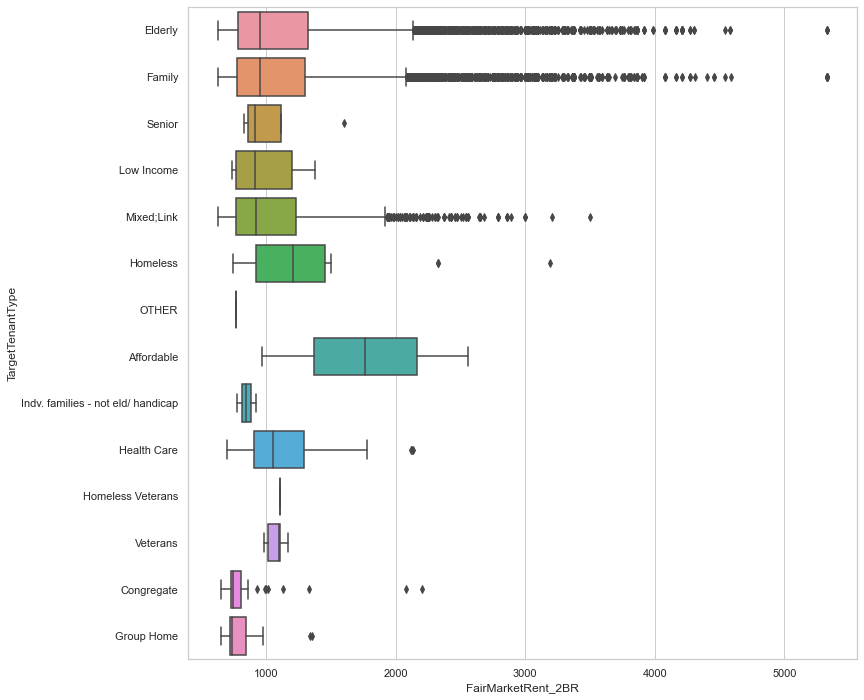

In [354]:
match_and_replace(nhpd, 'TargetTenantType', 'Mixed')
match_and_replace(nhpd, 'TargetTenantType', 'Mixed;Link')
match_and_replace(nhpd, 'TargetTenantType', 'Elderly or Disabled')
match_and_replace(nhpd, 'TargetTenantType', 'Family')
match_and_replace(nhpd, 'TargetTenantType', 'Elderly')
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.boxplot(y="TargetTenantType", x="FairMarketRent_2BR", data=nhpd)

#### Let's explore the LIHTC i.e. the 'Low Income Housing Tax Credit' housing subsidies for Florida and compare them with rest of the USA

In [355]:
# Lets explore the the florida data
florida_df = nhpd[nhpd['State'] == 'FL']
florida_df.head()

,NHPDPropertyID,PropertyName,PropertyAddress,City,State,Zip,CBSACode,CBSAType,County,CountyCode,...,NumberActiveMR,NumberInconclusiveMR,NumberInactiveMR,Mr_1_Status,Mr_1_ProgramName,Mr_1_AssistedUnits,Mr_2_Status,Mr_2_ProgramName,Mr_2_AssistedUnits,OldNHPDPropertyID
144,1000147,SUNTERRA APARTMENTS,3541 Evans Ave,Fort Myers,FL,33901-8328,15980.0,Metropolitan Statistical Area,Lee,12071.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159,1000163,BUENA VISTA APARTMENTS,521 SW 6th St,Miami,FL,33130-2773,33100.0,Metropolitan Statistical Area,Miami-Dade,12086.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161,1000165,VILLA BEATRIZ,776 NW 2nd St,Miami,FL,33128-1454,33100.0,Metropolitan Statistical Area,Miami-Dade,12086.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,1000172,PORTILLO APARTMENTS,3559 Portillo Rd,Spring Hill,FL,34608,45300.0,Metropolitan Statistical Area,Hernando,12053.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,1000611,PHASE IV-B,4231 Machiavelli Ln,Fort Myers,FL,33916-4870,15980.0,Metropolitan Statistical Area,Lee,12071.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [356]:
# Get the rest of US data for comparison with Florida data
rest_US = nhpd[nhpd['State'] != 'FL']
rest_US.head()

,NHPDPropertyID,PropertyName,PropertyAddress,City,State,Zip,CBSACode,CBSAType,County,CountyCode,...,NumberActiveMR,NumberInconclusiveMR,NumberInactiveMR,Mr_1_Status,Mr_1_ProgramName,Mr_1_AssistedUnits,Mr_2_Status,Mr_2_ProgramName,Mr_2_AssistedUnits,OldNHPDPropertyID
0,1000000,IVY ESTATES,6729 Zeigler Blvd,Mobile,AL,36608-4253,33660.0,Metropolitan Statistical Area,Mobile,1097.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000001,RENDU TERRACE WEST,7400 Old Shell Rd,Mobile,AL,36608-4549,33660.0,Metropolitan Statistical Area,Mobile,1097.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000002,TWB RESIDENTIAL OPPORTUNITIES II,93 Canal Rd,Port Jefferson Station,NY,11776-3024,35620.0,Metropolitan,Suffolk,36103.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000003,THE DAISY HOUSE,615 Clarissa St,Rochester,NY,14608-2485,40380.0,Metropolitan,Monroe,36055.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000004,MAIN AVENUE APARTMENTS,105 E Walnut St,Sylacauga,AL,35150-3012,45180.0,Micropolitan Statistical Area,Talladega,1121.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [357]:
# Total number of units covered by subsidy for florida and the rest of US

LIHTC_florida = florida_df[['City', 'LIHTC_1_AssistedUnits', 'NumberActiveLihtc', 'NumberInconclusiveLihtc', 
                            'NumberInactiveLihtc', 'LIHTC_2_AssistedUnits', 'LIHTC_1_ProgramName', 
                            'TargetTenantType', 'FairMarketRent_2BR']]


LIHTC_florida.dropna(inplace=True)

/Users/farazrahman/mapping-floodwater/env/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


<AxesSubplot:ylabel='City'>

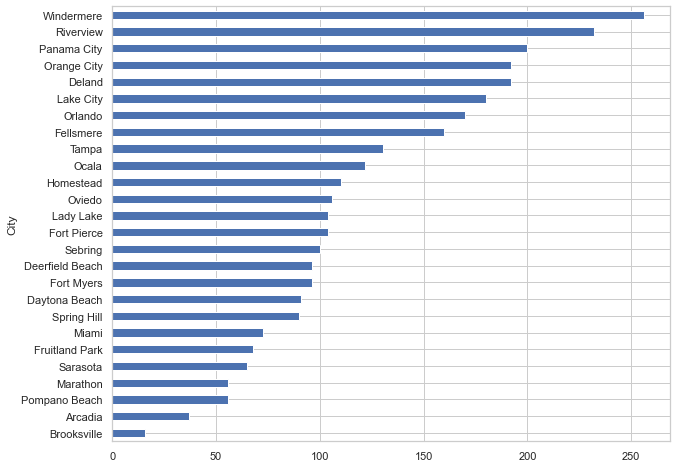

In [358]:
# On an average how many LIHTC units are covered by subsidies in some of the cities in Florida
# Below is the list of cities with LIHTC assisted units for florida 
fig, ax = plt.subplots(figsize=(10,8))
LIHTC_florida.groupby('City')['LIHTC_1_AssistedUnits'].mean().sort_values().plot.barh()

###### For Florida we can see that around 120 LIHTC assisted units are covered with subsidies on an average

In [359]:
LIHTC_florida.groupby('City')['LIHTC_1_AssistedUnits'].mean().describe()

count     26.000000
mean     119.297436
std       61.179588
min       16.000000
25%       77.000000
50%      104.000000
75%      167.500000
max      256.000000
Name: LIHTC_1_AssistedUnits, dtype: float64

###### When comparing with the rest of the US we can see that around 60 LIHTC assisted units are covered with subsidies on an average

In [360]:
# Total number of units covered by subsidy for florida and the rest of US

LIHTC_rest_US = rest_US[['City', 'LIHTC_1_AssistedUnits', 'LIHTC_2_AssistedUnits', 
                         'NumberActiveLihtc', 'NumberInconclusiveLihtc', 
                        'NumberInactiveLihtc', 'LIHTC_1_ProgramName', 
                         'TargetTenantType', 'FairMarketRent_2BR']]


LIHTC_rest_US.dropna(inplace=True)

LIHTC_rest_US.groupby('City')['LIHTC_1_AssistedUnits'].mean().describe()

/Users/farazrahman/mapping-floodwater/env/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


count    742.000000
mean      61.502080
std       48.593584
min        0.000000
25%       31.000000
50%       48.000000
75%       80.000000
max      454.333333
Name: LIHTC_1_AssistedUnits, dtype: float64

###### Number of active LIHTC subsidies in Florida grouped by city- On an average there are just 2-4 active LIHTC subsidies for cities in Florida

<AxesSubplot:ylabel='City'>

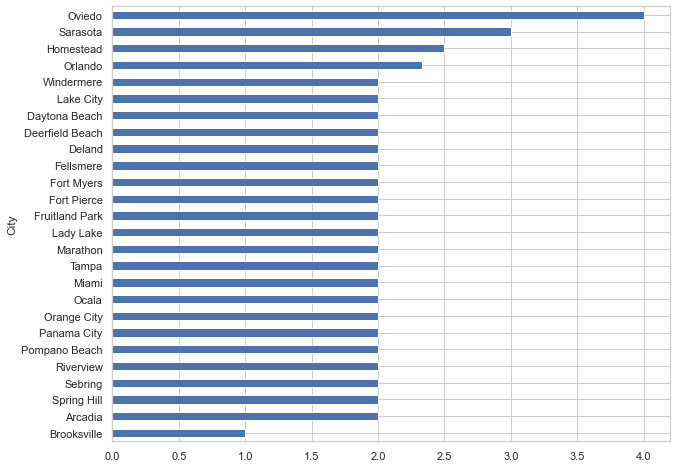

In [361]:
fig, ax = plt.subplots(figsize=(10,8))
LIHTC_florida.groupby('City')['NumberActiveLihtc'].mean().sort_values().plot.barh()

In [362]:
LIHTC_florida.groupby('City')['NumberActiveLihtc'].mean().describe()

count    26.000000
mean      2.108974
std       0.492031
min       1.000000
25%       2.000000
50%       2.000000
75%       2.000000
max       4.000000
Name: NumberActiveLihtc, dtype: float64

###### Number of active LIHTC subsidies for rest of the US grouped by city- On an average there are just 2-5 active LIHTC subsidies for cities all over the USA

In [363]:
LIHTC_rest_US.groupby('City')['NumberActiveLihtc'].mean().describe()

count    742.000000
mean       2.004336
std        0.413583
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: NumberActiveLihtc, dtype: float64